In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import seaborn as sns
import tools

In [3]:
# plt.style.use("coolbeans")
sns.set_style("whitegrid")
matplotlib.rcParams.update({'font.size': 10})
np.random.seed(123)

In [4]:
DB_PATH = "./data/stationdb.sqlite"
TCR_PATH = "./data/20th_rean_V2.npz"
ERSST_PATH = "./data/ersst.npz"
WESTOFLON = -104
EASTOFLON = -125
WATER_YEAR = {"low": 1981,
              "high": 2011}
WY_RANGE = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}
WESTOFLON = -104
EASTOFLON = -125
MC_NRUNS = 1000

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, year, mean FROM StationWY WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) GROUP BY stationid, year ORDER BY stationid, year ASC".format(wy_low = str(WATER_YEAR["low"]), wy_high = str(WATER_YEAR["high"]), seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["year", "stationid"])
conn.close()

In [6]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, latgage, longage FROM StationInfo WHERE stationid IN ({seq}) ORDER BY stationid ASC".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

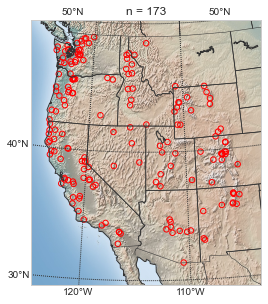

In [7]:
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## Mapped SSI linear trend

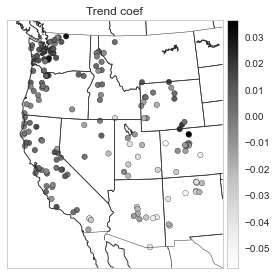

In [8]:
# Parse and shape the data we grabbed. Standardize it. Grad trend coefficients.
parsed = raw.groupby(level = "stationid")["mean"].transform(tools.spigamma)

trend_coefs = parsed.groupby(level = "stationid").apply(tools.trender)
# Detrending. Let's see what happens.
# parsed = parsed.groupby(level = "stationid").transform(signal.detrend)
# parsed = parsed.unstack()

# Map trend coefs.
out = tools.plot_trendmap(trend_coefs, latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## Basic North Test scree plot

In [9]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 6
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

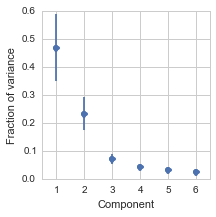

In [10]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [11]:
retain_modes = 2

## PC time series from leading components

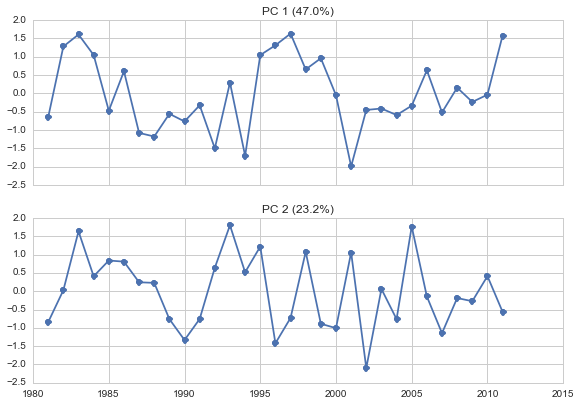

In [12]:
out = tools.plot_pc(solver, yr = WY_RANGE, nmodes = retain_modes)

## Leading EOFs mapped as covariance

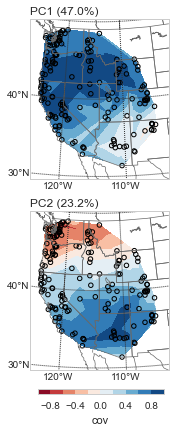

In [13]:
out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes,
                     figure_size = (2.5, 6.5))
plt.savefig("./plots/fig1.eps")

## Leading two modes as vectors

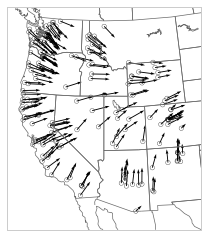

In [14]:
# Linear regression of the first two leading PCs onto the gage time series to get regression coefficients.
rcoef1 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])

out = tools.plot_vectormap(coef1 = rcoef1, coef2 = rcoef2,
                           lat = latlon["latgage"].as_matrix(),
                           lon = latlon["longage"].as_matrix())

# Point correlation maps

## Antecedent JJA 500 mb geopotential height

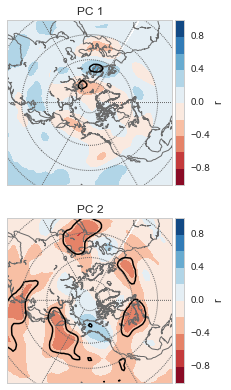

In [15]:
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
hgts = tcr["data"][3, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts,
                         lat = tcr["lat"], lon = tcr["lon"],
                         nmodes = retain_modes)

## Antecedent SON 500 mb geopotential height

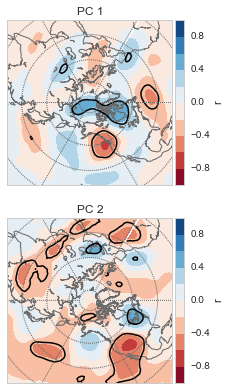

In [16]:
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
hgts = tcr["data"][2, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts,
                         lat = tcr["lat"], lon = tcr["lon"],
                         nmodes = retain_modes)

## Northern hemisphere DJF 500 mb geopotential height

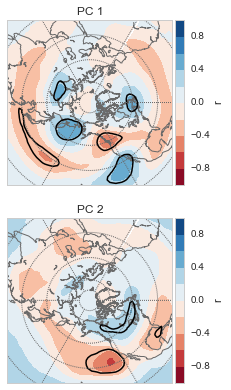

In [17]:
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts,
                         lat = tcr["lat"], lon = tcr["lon"],
                         nmodes = retain_modes)

33


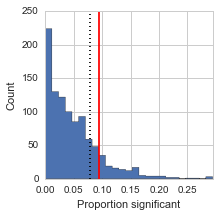

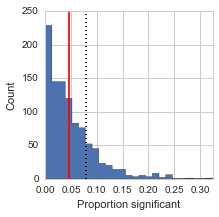

In [18]:
# This is a bit tricky. We're croping the hgts field to everything 
# above a target latitude and then running our field sig test. This 
# code is poorly implimented and should be tested, especialy if used 
# against another rean. product.

crop_at_lat = 23
lat_as_index = np.max(np.where(tcr["lat"] > crop_at_lat)[0])
print(lat_as_index)
for i in range(retain_modes):
    noise_distribution, star = tools.pearson_fieldsig_test(pc[:, i], hgts.copy()[:, :lat_as_index, :], 
                                                           tcr["lat"][:lat_as_index, :], 
                                                           local_alpha = 0.05, 
                                                           nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

## MAM 500 mb geopotential height

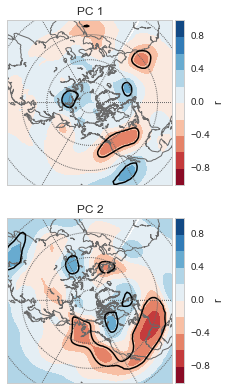

In [19]:
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
hgts = tcr["data"][1, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts,
                         lat = tcr["lat"], lon = tcr["lon"],
                         nmodes = retain_modes)

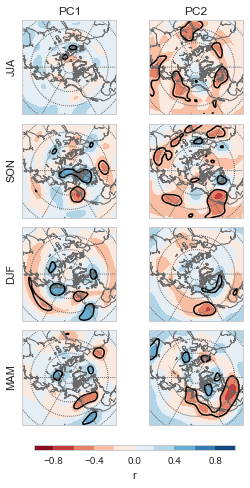

In [20]:
# Plot for figure 2
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
lat = tcr["lat"]
lon = tcr["lon"]
pc = solver.pcs(npcs = 2, pcscaling = 1)
fig = plt.figure(figsize = (4, 7))
divs = np.linspace(-1, 1, 11)
msk = None
world_map = False
alpha=[0.05]

##################################### PC1
i = 0

## JJA
hgts = tcr["data"][3, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(421)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
title_str = "PC" + str(i + 1)
ax.set_title(title_str)
plt.ylabel("JJA")

## SON
hgts = tcr["data"][2, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

ax = fig.add_subplot(423)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
plt.ylabel("SON")
# title_str = "ASO PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## DJF
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(425)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
plt.ylabel("DJF")
# title_str = "NDJ PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## MAM
hgts = tcr["data"][1, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(427)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
plt.ylabel("MAM")
# title_str = "FMA PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

##################################### PC 2
i = 1

## JJA

hgts = tcr["data"][3, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(422)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
title_str = "PC" + str(i + 1)
ax.set_title(title_str)


# SON
hgts = tcr["data"][2, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts

i = 1
ax = fig.add_subplot(424)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "ASO PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## DJF
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(426)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "NDJ PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## MAM
hgts = tcr["data"][1, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
field = hgts
ax = fig.add_subplot(428)

r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "FMA PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

# fig.subplots_adjust(right = 0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

fig.tight_layout()

fig.subplots_adjust(bottom = 0.15)
cax = fig.add_axes([0.17, 0.1, 0.7, 0.01])
cb = plt.colorbar(ctf1, cax = cax, orientation='horizontal')
cb.set_label("r")

# plt.savefig("./plots/fig2.png", dpi = 300)
plt.savefig("./plots/fig2.eps")
# plt.show()

## Detrended antecedent JJA global SST

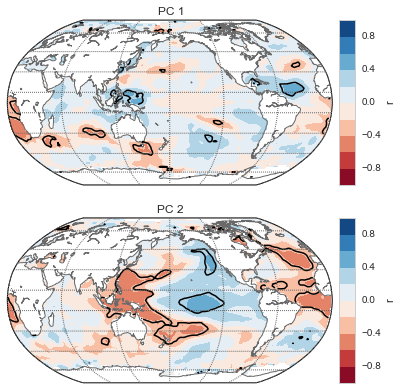

In [21]:
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
sst = ersst["data"][3, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, 
                         lat = ersst["lat"], lon = ersst["lon"], 
                         nmodes = retain_modes, 
                         msk = ersst["landmask"], world_map = True)

## Detrended antecedent SON global SST

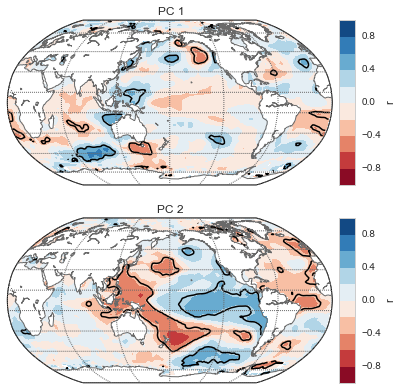

In [22]:
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
sst = ersst["data"][2, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, 
                         lat = ersst["lat"], lon = ersst["lon"], 
                         nmodes = retain_modes, 
                         msk = ersst["landmask"], world_map = True)

## Detrended DJF global SST

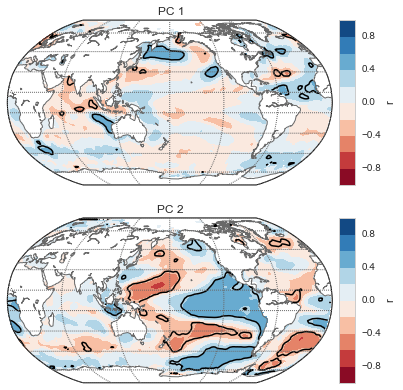

In [23]:
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, 
                         lat = ersst["lat"], lon = ersst["lon"], 
                         nmodes = retain_modes, 
                         msk = ersst["landmask"], world_map = True)

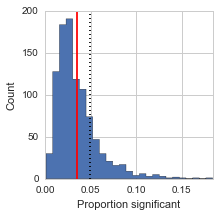

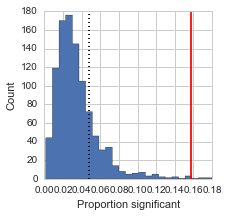

In [24]:
for i in range(retain_modes):
    noise_distribution, star = tools.pearson_fieldsig_test(pc[:, i], sst.copy(), 
                                                           ersst["lat"], 
                                                           local_alpha = 0.05, 
                                                           nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

## Detrended MAM global SST

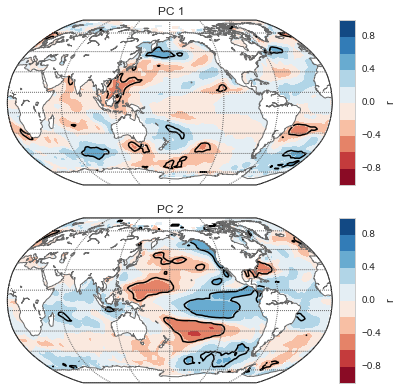

In [25]:
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
sst = ersst["data"][1, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, 
                         lat = ersst["lat"], lon = ersst["lon"], 
                         nmodes = retain_modes, 
                         msk = ersst["landmask"], world_map = True)

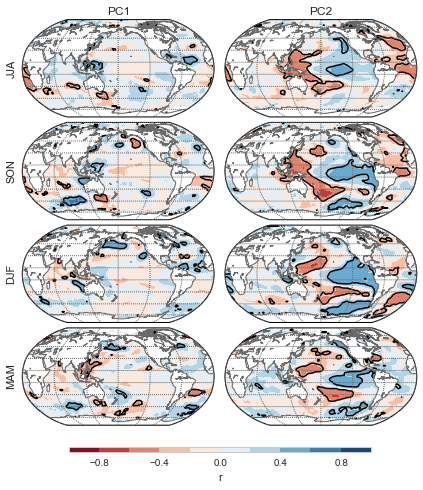

In [26]:
# Plot for figure 3
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
lat = ersst["lat"]
lon = ersst["lon"]
pc = solver.pcs(npcs = 2, pcscaling = 1)
fig = plt.figure(figsize = (6, 7))
divs = np.linspace(-1, 1, 11)
msk = ersst["landmask"]
world_map = True
alpha=[0.05]

##################################### PC1
i = 0

## JJA
sst = ersst["data"][3, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(421)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
title_str = "PC" + str(i + 1)
ax.set_title(title_str)
plt.ylabel("JJA")

## SON
sst = ersst["data"][2, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(423)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
plt.ylabel("SON")
# title_str = "ASO PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## DJF
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(425)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
plt.ylabel("DJF")
# title_str = "NDJ PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## MAM
sst = ersst["data"][1, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(427)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
plt.ylabel("MAM")
# title_str = "FMA PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

##################################### PC 2
i = 1

## JJA

sst = ersst["data"][3, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(422)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
title_str = "PC" + str(i + 1)
ax.set_title(title_str)


# SON
sst = ersst["data"][2, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

i = 1
ax = fig.add_subplot(424)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "ASO PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## DJF
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(426)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "NDJ PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

## MAM
sst = ersst["data"][1, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
field = sst

ax = fig.add_subplot(428)
r, p = tools.pearson_corr(pc[:, i], field.copy())
if np.any(msk):
    r = np.ma.masked_array(r, msk)
    p = np.ma.masked_array(p, msk)
m = None
if world_map:
    m = Basemap(ax = ax, projection = "robin", lon_0 = 180, resolution = "c")
else:
    m = Basemap(ax = ax, projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
x, y = m(lon, lat)
m.drawcoastlines(color = "#696969")
m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
ctf1 = m.contourf(x, y, r, divs, cmap = plt.cm.RdBu)
ctf2 = m.contour(x, y, p, alpha, colors = "k", linewidths = 1.5)
# cb = m.colorbar(ctf1)
# cb.set_label("r")
# title_str = "FMA PC" + str(i + 1)
# ax.set_title(title_str, loc = "left")

# fig.subplots_adjust(right = 0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

fig.tight_layout()

fig.subplots_adjust(bottom = 0.15)
cax = fig.add_axes([0.17, 0.1, 0.7, 0.01])
cb = plt.colorbar(ctf1, cax = cax, orientation='horizontal')
cb.set_label("r")

# plt.savefig("./plots/fig3.png", dpi = 300)
plt.savefig("./plots/fig3.eps")
# plt.show()

# Composite maps

## Northern hemisphere DJF 500 mb geopotential height

In [27]:
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
hgts = tcr["data"][0, 1, msk_time]

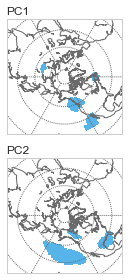

In [28]:
out = tools.plot_ttest(solver, hgts, 
                       lat = tcr["lat"], lon = tcr["lon"], 
                       nmodes = retain_modes,
                       figure_size = (2, 4))
plt.savefig("./plots/fig4.eps")

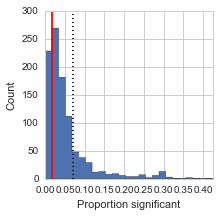

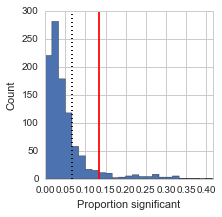

In [29]:
for i in range(retain_modes):
    noise_distribution, star = tools.ttest_fieldsig_test(pc[:, i], hgts.copy(), 
                                                         tcr["lat"],
                                                         local_alpha = 0.05, 
                                                         nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

## Detrended DJF global SST

In [30]:
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)

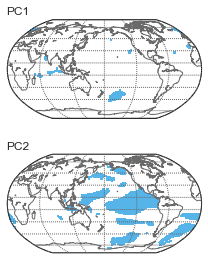

In [31]:
out = tools.plot_ttest(solver, sst, 
                         lat = ersst["lat"], lon = ersst["lon"], 
                         nmodes = retain_modes, 
                         msk = ersst["landmask"], world_map = True,
                         figure_size = (3, 4))
plt.savefig("./plots/fig5.eps")

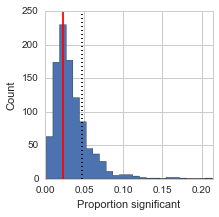

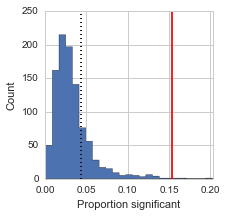

In [32]:
for i in range(retain_modes):
    noise_distribution, star = tools.ttest_fieldsig_test(pc[:, i], sst.copy(), 
                                                         ersst["lat"], 
                                                         local_alpha = 0.05, 
                                                         nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)